# DeepLab 기반 세그멘테이션

* DeepLab V1: [Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs](https://arxiv.org/abs/1412.7062), ICLR 2015.
  - Atrous convolution은 기존 convolution과 다르게 필터 내부에 빈 공간을 둔 채로 작동
  - 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서 field of view (한 픽셀이 볼 수 있는 영역)를 크게 가져갈 수 있음
  - Semantic segmentation에서 일반적으로 높은 성능을 내기 위해서는 convolutional neural network의 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field 크기가 중요
  - Atrous convolution을 활용하면 파라미터 수를 늘리지 않으면서도 receptive field를 크게 키울 수 있기 때문에 DeepLab 계열에서는 이를 적극적으로 활용

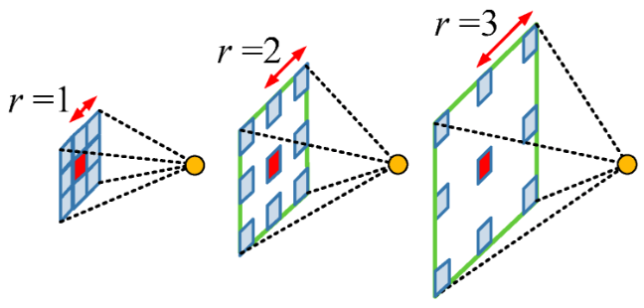

* DeepLab V2: [DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs](https://arxiv.org/abs/1606.00915), TPAMI 2017.
  - Semantic segmentaion의 성능을 높이기 위한 방법 중 하나로, spatial pyramid pooling 기법을 자주 사용
  - Feature map으로부터 여러 개의 rate가 다른 atrous convolution을 병렬로 적용한 뒤, 이를 다시 합쳐주는 atrous spatial pyramid pooling (ASPP) 기법을 활용
  - multi-scale context를 모델 구조로 구현하여 보다 정확한 semantic segmentation을 수행할 수 있도록 함

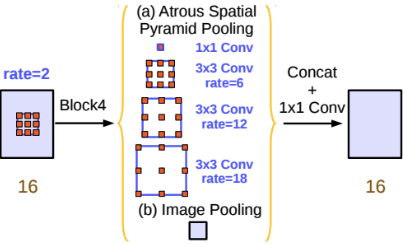

* DeepLab V3: [Rethinking Atrous Convolution for Semantic Image Segmentation](https://arxiv.org/abs/1706.05587), arXiv 2017.

  - Encoder: ResNet with Atrous convolution
  - Atrous Spatial Pyramid Pooling (ASPP)
  - Decoder: Bilinear Upsampling


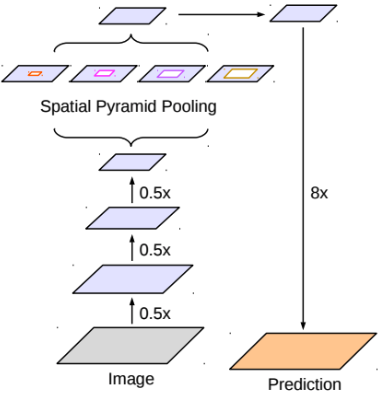

* DeepLab V3+: [Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf), arXiv 2018.

  - Encoder: ResNet with Atrous Convolution → Xception (Inception with Separable Convolution)
  - ASPP → ASSPP (Atrous Separable Spatial Pyramid Pooling)
  - Decoder: Bilinear Upsampling → Simplified U-Net style decoder

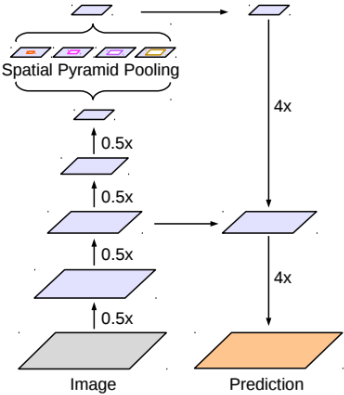

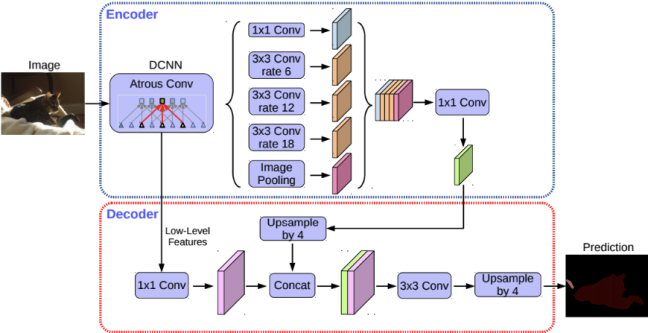

## 데이터셋 다운로드

* Crowd Instance-level Human Parsing (CIHP)(https://arxiv.org/abs/1811.12596)
* 38,280개의 다양한 인간 이미지
* instance-level-human-parsing.zip(2.7G): https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz

In [ ]:
!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:27<00:00, 104MB/s]


In [ ]:
!ls

 drive			        instance-level_human_parsing	   sample_data
'ICCV15_fashion_dataset(ATR)'   instance-level-human-parsing.zip


In [ ]:
!ls instance-level_human_parsing/instance-level_human_parsing/Training

Categories    Human	 Images        Instances
Category_ids  Human_ids  Instance_ids  train_id.txt


In [ ]:
import os 
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
# DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
DATA_DIR = "/content/instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

In [ ]:
train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]

val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

In [ ]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

In [ ]:
def load_data(image_list, mask_list):
  image = read_image(image_list)
  mask = read_image(mask_list, mask=True)

  return image,

In [ ]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [ ]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None),)>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None),)>


## 모델 구성

* 인코더-디코더 구조를 확장
* 인코더 모듈: 확장된 컨볼루션(atrous conv)을 여러 척도로 적용하여 다중 스케일 상황 정보 처리
* 디코더 모듈: 객체 경계를 따라 분할 결과 조정


* 확장된 컨볼루션(Dilated convolution)
  - 컨볼루션 확장을 통해 네트워크 깊숙히 들어가며 스트라이드를 일정하게 유지 가능
  - 매개변수의 수나 계산량을 늘리지 않고도 더 큰 시야를 가질 수 있음
  - 더 큰 특징 맵 출력이 가능하여 세그멘테이션에 유용함

* 확장된 공간 피라미드 풀링(Dilated Spatial Pyramid Pooling)
  - 샘플링 속도가 커질수록 유효한 필터 가중치(유효한 특징 영역에 적용되는 가중치)의 수가 작아짐


![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)




"""
## Building the DeepLabV3+ model
DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module
processes multiscale contextual information by applying dilated convolution at multiple
scales, while the decoder module refines the segmentation results along object boundaries.
![](https://github.com/lattice-ai/DeepLabV3-Plus/raw/master/assets/deeplabv3_plus_diagram.png)
**Dilated convolution:** With dilated convolution, as we go deeper in the network, we can keep the
stride constant but with larger field-of-view without increasing the number of parameters
or the amount of computation. Besides, it enables larger output feature maps, which is
useful for semantic segmentation.
The reason for using **Dilated Spatial Pyramid Pooling** is that it was shown that as the
sampling rate becomes larger, the number of valid filter weights (i.e., weights that
are applied to the valid feature region, instead of padded zeros) becomes smaller.
"""

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [ ]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

* 사전 훈련된 ResNet50을 백본 모델로 사용
* `conv4_block6_2_relu` 블록에서 저수준의 특징 사용

* 인코더 특징은 인자 4에 의해 bilinear 업샘플링
* 동일한 공간 해상도를 가진 네트워크 백본에서 저수준 특징과 연결


"""
The encoder features are first bilinearly upsampled by a factor 4, and then
concatenated with the corresponding low-level features from the network backbone that
have the same spatial resolution. For this example, we
use a ResNet50 pretrained on ImageNet as the backbone model, and we use
the low-level features from the `conv4_block6_2_relu` block of the backbone.
"""

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

## 모델 학습

"""
We train the model using sparse categorical crossentropy as the loss function, and
Adam as the optimizer.
"""

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

Epoch 1/3


ValueError: ignored

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(loss, clor='blue', label='train_loss')
ax1.plot(val_loss, color='red', label='val_loss')
ax1_set_title("Train and Validation Loss")
ax1. set_xlabel('Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()


############

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(accuracy, color='blue', label='train_accuracy')
ax2.plot(val_accuracy, color='red', label='val_accuracy')
ax2_set_title("Train and Validation accuracy")
ax2. set_xlabel('Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('accuracy')
ax2.grid()
ax2.legend()

NameError: ignored

In [ ]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

## 추론

* 데이터셋과 함께 제공된 `./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat` 파일을 통해 각 라벨에 대한 해당 색상을 찾을 수 있음


In [ ]:
"""
## Inference using Colormap Overlay
The raw predictions from the model represent a one-hot encoded tensor of shape `(N, 512, 512, 20)`
where each one of the 20 channels is a binary mask corresponding to a predicted label.
In order to visualize the results, we plot them as RGB segmentation masks where each pixel
is represented by a unique color corresponding to the particular label predicted. We can easily
find the color corresponding to each label from the `human_colormap.mat` file provided as part
of the dataset. We would also plot an overlay of the RGB segmentation mask on the input image as
this further helps us to identify the different categories present in the image more intuitively.
"""

colormap = loadmat("./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat")["colormap"]

colormap = colormap * 100
colormap = colormap.astype(np.uint8)

In [ ]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [ ]:
def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay

In [ ]:
def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()

In [ ]:
def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

In [ ]:
### Inference on Train Images
plot_predictions(train_images[:4], colormap, model=model)

In [ ]:
"""
### Inference on Validation Images
You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/deeplabv3p-resnet50)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/Human-Part-Segmentation).
"""

plot_predictions(val_images[:4], colormap, model=model)